# **Relationship between Self-Attention and Convolution**
This notebook intends to provide an empirical evidence for the theoretical proof concerning the relationship between Self-Attention layers and Convolutional layers. The idea for this work has been adopted from the original paper titled: [**On the Relationship between Self-Attention and Convolutional Layers**](https://arxiv.org/pdf/1911.03584.pdf) (by Cordonnier et al, ICLR 2020).
<br>
We have performed a moderately complex task of Time-Series Classification in this notebook, as of yet. Our final objective is, to give an empirical evidence of why Self-Attention is capable of replacing Convolution without any significant reduction in performance. More details about the dataset can be found later in this notebook.

### Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys, random
from sklearn.model_selection import train_test_split

In [2]:
%matplotlib inline

In [3]:
from torch.utils.data import Dataset, TensorDataset, DataLoader

In [4]:
import models, utils

In [5]:
from torchsummary import summary

### Dataset Implementation

In [6]:
raw_data_dir = './whole_data'

In [7]:
subject_list = os.listdir(raw_data_dir)
print(len(subject_list))

69


In [8]:
random.seed(1)

In [9]:
subject_df = pd.read_csv(os.path.join(raw_data_dir, random.choice(subject_list)))
subject_df.head()

,AB_I_O,AB_PHI_O,AB_I_DO,AB_PHI_DO,CD_I_O,CD_PHI_O,CD_I_DO,CD_PHI_DO,label
0,0.275960,0.051303,0.091763,-0.044598,0.014088,0.283515,0.328312,0.088877,0
1,0.247073,0.041880,0.087941,-0.035670,-0.040156,0.444357,0.333307,0.057275,0
2,0.219966,0.037286,0.084897,-0.030853,-0.089000,0.616255,0.336260,0.022443,0
3,0.195418,0.038564,0.082599,-0.029996,-0.131033,0.792589,0.336908,-0.014349,0
4,0.174229,0.046410,0.080965,-0.032637,-0.165057,0.967083,0.334975,-0.051811,0


In [10]:
# checking if the dataset is balanced
subject_df.iloc[:, -1].value_counts()

0    1704
1    1704
2    1704
3    1704
Name: label, dtype: int64

In [11]:
# for a window_size = 150 (~30s) and stride = 3 (~0.6s)
# sampling frequency for the data = 5.2Hz (Ts~0.2s)
slide_window_data = utils.extract_sliding_window(subject_df)

In [12]:
slide_window_data.head()

,AB_I_O,AB_PHI_O,AB_I_DO,AB_PHI_DO,CD_I_O,CD_PHI_O,CD_I_DO,CD_PHI_DO,label,window
0,0.251090,-0.127196,0.014890,0.027926,-0.227493,0.191236,0.015056,-0.232111,0,0
1,0.239895,-0.095349,0.015898,-0.000577,-0.231132,0.161360,0.016941,-0.215199,0,0
2,0.232039,-0.067809,0.016425,-0.031034,-0.234026,0.159570,0.019698,-0.205297,0,0
3,0.227504,-0.045332,0.016339,-0.062451,-0.236548,0.187071,0.023307,-0.203764,0,0
4,0.226260,-0.028519,0.015534,-0.093858,-0.238990,0.243260,0.027707,-0.211319,0,0


In [13]:
num_windows = len(slide_window_data.iloc[:, -1].unique())
print("Number of windows (size=150, stride=3) in the dataset: {}".format(num_windows))

Number of windows (size=150, stride=3) in the dataset: 1216


In [14]:
features, labels = utils.data_loading_function(slide_window_data)
print("shape features: {}, shape labels: {}".format(features.shape, labels.shape))

shape features: (1216, 150, 8), shape labels: (1216,)


In [15]:
# train-val-test split (70/15/15)
trainval_features, test_features = train_test_split(features, test_size=0.15)
trainval_labels, test_labels = train_test_split(labels, test_size=0.15)
train_features, val_features = train_test_split(trainval_features, test_size=0.15)
train_labels, val_labels = train_test_split(trainval_labels, test_size=0.15)

In [16]:
print("shape train: {}, shape validation: {}, shape test: {}".format(
    train_features.shape, val_features.shape, test_features.shape
))

shape train: (878, 150, 8), shape validation: (155, 150, 8), shape test: (183, 150, 8)


In [17]:
train_feature_tensor = torch.Tensor(train_features)
train_label_tensor = torch.Tensor(train_labels)
val_feature_tensor = torch.Tensor(val_features)
val_label_tensor = torch.Tensor(val_labels)
test_feature_tensor = torch.Tensor(test_features)
test_label_tensor = torch.Tensor(test_labels)

In [18]:
trainset = TensorDataset(train_feature_tensor, train_label_tensor)
valset = TensorDataset(val_feature_tensor, val_label_tensor)
testset = TensorDataset(test_feature_tensor, test_label_tensor)

### Model Implementation
Transformer classifier and Deep Convnet

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
num_features = 8
num_classes = 4
hidden_size = 100

In [21]:
%%capture
convnet = models.ConvNet(window_size=150, num_features=num_features, num_classes=num_classes)
tfclassifier = models.TransformerClassifier(num_labels=num_classes, embed_size=num_features, 
                                            hidden_size=hidden_size, device=device)
convnet.to(device)
tfclassifier.to(device)

In [22]:
summary(convnet, (150, 8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 25, 8, 143]             225
            Conv2d-2           [-1, 25, 1, 143]           5,000
       BatchNorm2d-3           [-1, 25, 1, 143]              50
              ReLU-4           [-1, 25, 1, 143]               0
         MaxPool2d-5            [-1, 25, 1, 71]               0
           Dropout-6            [-1, 25, 1, 71]               0
            Conv2d-7            [-1, 50, 1, 64]          10,000
       BatchNorm2d-8            [-1, 50, 1, 64]             100
              ReLU-9            [-1, 50, 1, 64]               0
        MaxPool2d-10            [-1, 50, 1, 32]               0
          Dropout-11            [-1, 50, 1, 32]               0
           Conv2d-12            [-1, 50, 1, 25]          20,000
      BatchNorm2d-13            [-1, 50, 1, 25]             100
             ReLU-14            [-1, 50

In [23]:
summary(tfclassifier, (150, 8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1               [-1, 150, 8]               0
            Linear-2            [-1, 150, 2, 4]              16
            Linear-3            [-1, 150, 2, 4]              16
            Linear-4            [-1, 150, 2, 4]              16
            Linear-5               [-1, 150, 8]              72
     SelfAttention-6               [-1, 150, 8]               0
         LayerNorm-7               [-1, 150, 8]              16
           Dropout-8               [-1, 150, 8]               0
            Linear-9              [-1, 150, 16]             144
             ReLU-10              [-1, 150, 16]               0
           Linear-11               [-1, 150, 8]             136
        LayerNorm-12               [-1, 150, 8]              16
          Dropout-13               [-1, 150, 8]               0
 TransformerBlock-14               [-1,

### Training and Validation

In [24]:
import trainer

In [25]:
batch_size = 32
num_epochs = 200
learn_rate = 0.01

In [26]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [27]:
train_loss_history = trainer.train(convnet, trainloader, learning_rate=learn_rate,
                                    num_epochs=num_epochs, batch_size=batch_size, device=device)

Epoch [0/200], Step[1/28], Loss: 1.4900
Epoch [0/200], Step[2/28], Loss: 2.2834
Epoch [0/200], Step[3/28], Loss: 3.0367
Epoch [0/200], Step[4/28], Loss: 1.9285
Epoch [0/200], Step[5/28], Loss: 1.8117
Epoch [0/200], Step[6/28], Loss: 2.1847
Epoch [0/200], Step[7/28], Loss: 1.6045
Epoch [0/200], Step[8/28], Loss: 1.5799
Epoch [0/200], Step[9/28], Loss: 2.2196
Epoch [0/200], Step[10/28], Loss: 1.5826
Epoch [0/200], Step[11/28], Loss: 1.8525
Epoch [0/200], Step[12/28], Loss: 1.7473
Epoch [0/200], Step[13/28], Loss: 1.7258
Epoch [0/200], Step[14/28], Loss: 1.5589
Epoch [0/200], Step[15/28], Loss: 1.7782
Epoch [0/200], Step[16/28], Loss: 1.6048
Epoch [0/200], Step[17/28], Loss: 1.5904
Epoch [0/200], Step[18/28], Loss: 1.4936
Epoch [0/200], Step[19/28], Loss: 1.6224
Epoch [0/200], Step[20/28], Loss: 1.6571
Epoch [0/200], Step[21/28], Loss: 1.6696
Epoch [0/200], Step[22/28], Loss: 1.5881
Epoch [0/200], Step[23/28], Loss: 1.4875
Epoch [0/200], Step[24/28], Loss: 1.4532
Epoch [0/200], Step[25/28

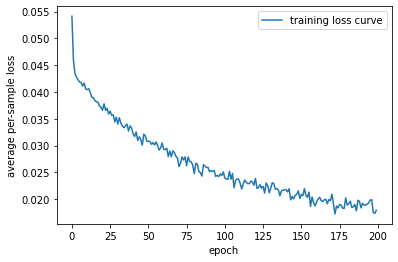

In [28]:
# average per-sample loss per epoch
plt.plot(np.arange(num_epochs), train_loss_history)
plt.xlabel('epoch')
plt.ylabel('average per-sample loss')
plt.legend(['training loss curve'])

In [29]:
# training the transformer model
train_loss_history_tf = trainer.train(tfclassifier, trainloader, learning_rate=learn_rate,
                                        num_epochs=200, batch_size=batch_size, device=device)

Epoch [0/200], Step[1/28], Loss: 1.3810
Epoch [0/200], Step[2/28], Loss: 1.9341
Epoch [0/200], Step[3/28], Loss: 1.6035
Epoch [0/200], Step[4/28], Loss: 2.1889
Epoch [0/200], Step[5/28], Loss: 2.4075
Epoch [0/200], Step[6/28], Loss: 2.1386
Epoch [0/200], Step[7/28], Loss: 1.6518
Epoch [0/200], Step[8/28], Loss: 1.5466
Epoch [0/200], Step[9/28], Loss: 1.6941
Epoch [0/200], Step[10/28], Loss: 1.9644
Epoch [0/200], Step[11/28], Loss: 1.4389
Epoch [0/200], Step[12/28], Loss: 1.4649
Epoch [0/200], Step[13/28], Loss: 1.4987
Epoch [0/200], Step[14/28], Loss: 1.4579
Epoch [0/200], Step[15/28], Loss: 1.4323
Epoch [0/200], Step[16/28], Loss: 1.3720
Epoch [0/200], Step[17/28], Loss: 1.3427
Epoch [0/200], Step[18/28], Loss: 1.4011
Epoch [0/200], Step[19/28], Loss: 1.4078
Epoch [0/200], Step[20/28], Loss: 1.3738
Epoch [0/200], Step[21/28], Loss: 1.3927
Epoch [0/200], Step[22/28], Loss: 1.5748
Epoch [0/200], Step[23/28], Loss: 1.4042
Epoch [0/200], Step[24/28], Loss: 1.3895
Epoch [0/200], Step[25/28

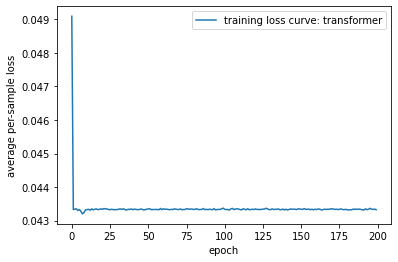

In [30]:
plt.plot(np.arange(200), train_loss_history_tf)
plt.xlabel('epoch')
plt.ylabel('average per-sample loss')
plt.legend(['training loss curve: transformer'])

### Testing

In [31]:
import validate

In [32]:
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [33]:
criterion = nn.CrossEntropyLoss()

In [34]:
test_loss1, test_acc1 = validate.eval_model(convnet, testloader, criterion, batch_size, device)
print(f"Accuracy on test dataset: {(100 * test_acc1):.2f}, Average per-sample loss: {(test_loss1):.4f}")

Accuracy on test dataset: 24.59, Average per-sample loss: 0.1031


In [35]:
test_loss2, test_acc2 = validate.eval_model(tfclassifier, testloader, criterion, batch_size, device)
print(f"Accuracy on test dataset: {(100 * test_acc2):.2f}, Average per-sample loss: {(test_loss2):.4f}")

Accuracy on test dataset: 22.95, Average per-sample loss: 0.0434
